# Modern Food Shift - An Analysis of New York Food Trucks on Yelp

## Install libraries 

In [1]:
#pip install pprint

%config IPCompleter.greedy = True

!pip install --upgrade yelpapi
!pip install --upgrade yelp

  Created wheel for yelp: filename=yelp-1.0.2-cp36-none-any.whl size=11805 sha256=2f05fd2e3c07b196a0320800be76e1db5590cc44bd80f1c9b7f34f6c1b3ab301
  Stored in directory: /root/.cache/pip/wheels/a5/1f/cb/cd71331e931f7b0e719d4319b8cc14e34faabac6946ff35aa4
Successfully built yelp


In [2]:
from __future__ import print_function
import requests
import yelpapi  
import argparse
import json
import pprint
import sys
import urllib

import pickle
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
from yelp.client import Client

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import preprocessing
from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OutputCodeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn import metrics
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.metrics import roc_curve, mean_squared_error
import xgboost as xgb
import math

from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers, layers
from keras.utils import np_utils

from IPython.display import display, HTML

Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Load data from Yelp

In [0]:
url_business ='https://api.yelp.com/v3/businesses'
url_search = 'https://api.yelp.com/v3/businesses/search'

CLIENT_KEY = "mkiXAI4ESi8xsGpizf7u0g"
MY_API_KEY = "zUHqRv5saa5CrIhddvDahzEsETysJgFkmyESbYzopq_Zh7Ca5wvtUyYWilD91h_Ff0WkownQoP4oz4z1KwwVPfnrtleB6ZvMPq_fbVYRPJBK_HZS0nlnIejQEP5bXnYx"

headers = {    'Authorization': 'Bearer {}'.format(MY_API_KEY),
}

In [0]:
def get_business_ids(term, offset_num): # This function launches the request for all grocery location endpoints 

    url_params = { #parameters passed to the API
        'term':term,'location':'Manhattan, New York, NY', 'limit':50,'offset': offset_num
        # offset: iterative from 50-1000
        # limit: Maximum return of results per request (ref: API documentation).
     }

    response = requests.get(url_search, headers=headers, params=url_params)
    return response.json() # Returns a JSON.

In [0]:
for offset_num in np.arange(0,1000,50) : 
        try:
            output_json1 = get_business_ids('Food Trucks',offset_num) 
            output_json2 = get_business_ids('Street Food',offset_num) 
            output_json3 = get_business_ids('Food Stands',offset_num) 
            output_json4 = get_business_ids('Street Vendors',offset_num)
            output_json5 = get_business_ids('Food Courts',offset_num) 
            
            #print(offset_num) 
            if offset_num == 0:
                df_first1 = pd.DataFrame.from_dict(output_json1['businesses'])
                df_first2 = pd.DataFrame.from_dict(output_json2['businesses'])
                df_first3 = pd.DataFrame.from_dict(output_json3['businesses'])
                df_first4 = pd.DataFrame.from_dict(output_json4['businesses'])
                df_first5 = pd.DataFrame.from_dict(output_json5['businesses'])
                # 'businesses' because that's the primary key of the JSON (i.e. pull all attribute data by calling 
                # that one key). This is something you can figure out reading the API documentation or visually
                # parsing the JSON. 
            else:
                df_rest1 = pd.DataFrame.from_dict(output_json1['businesses'])
                df_rest2 = pd.DataFrame.from_dict(output_json2['businesses'])
                df_rest3 = pd.DataFrame.from_dict(output_json3['businesses'])
                df_rest4 = pd.DataFrame.from_dict(output_json4['businesses'])
                df_rest5 = pd.DataFrame.from_dict(output_json5['businesses'])

                df_first1 = df_first1.append(df_rest1)
                df_first2 = df_first2.append(df_rest2)      
                df_first3 = df_first3.append(df_rest3)
                df_first4 = df_first4.append(df_rest4)  
                df_first5 = df_first5.append(df_rest5) 

        except AttributeError:
            print("error at ", offset_num) 

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [0]:
data_business_ids = pd.concat([pd.concat([pd.concat([pd.concat([df_first1,df_first2]),df_first3]), df_first4]), df_first5])
len(data_business_ids)

business_id_df = pd.DataFrame(data_business_ids['id'])

In [0]:
def get_req_json(url, params=None): # This function is a wrapper for a get request to the API.
    response = requests.get(url=url, headers=headers, params=params)
    return response.json()

def get_data(rids, api_url): # This function uses the Yelp business lookup API to get all data from each restaurant.
    info = []
    for idx, rid in rids.iterrows():
        url = "/".join([api_url, rid['id']])
        content = get_req_json(url)
        info.append(content)
    return info
    
# Uncomment the following two lines to get the data from the API
all_data = get_data(business_id_df, url_business)

# Checkpoint - Yelp Json Data

In [0]:
#pickle.dump(all_data, open("/content/gdrive/My Drive/Colab Notebooks/FoodTruck/Food_Truck_Data.pkl", "wb"))
all_data = pickle.load(open("/content/gdrive/My Drive/Colab Notebooks/FoodTruck/Food_Truck_Data.pkl", 'rb'))
all_data[0]


{'alias': 'steak-freak-new-york',
 'categories': [{'alias': 'foodtrucks', 'title': 'Food Trucks'},
  {'alias': 'steak', 'title': 'Steakhouses'}],
 'coordinates': {'latitude': 40.75991, 'longitude': -73.980429},
 'display_phone': '(607) 203-3239',
 'hours': [{'hours_type': 'REGULAR',
   'is_open_now': False,
   'open': [{'day': 0, 'end': '1500', 'is_overnight': False, 'start': '1030'},
    {'day': 1, 'end': '1500', 'is_overnight': False, 'start': '1030'},
    {'day': 2, 'end': '1500', 'is_overnight': False, 'start': '1030'},
    {'day': 3, 'end': '1500', 'is_overnight': False, 'start': '1030'},
    {'day': 4, 'end': '1500', 'is_overnight': False, 'start': '1030'}]}],
 'id': 'ZdhzqQd3haOn1eAiwH2WDw',
 'image_url': 'https://s3-media2.fl.yelpcdn.com/bphoto/R8taY9toN866B91arSTMcA/o.jpg',
 'is_claimed': True,
 'is_closed': False,
 'location': {'address1': '50 St 6th Ave',
  'address2': '',
  'address3': '',
  'city': 'New York',
  'country': 'US',
  'cross_streets': '',
  'display_address': 

In [0]:
data = pd.DataFrame.from_dict(all_data)

# Data Wrangling

In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3167 entries, 0 to 3166
Data columns (total 21 columns):
id               1631 non-null object
alias            1631 non-null object
name             1631 non-null object
image_url        1631 non-null object
is_claimed       1631 non-null object
is_closed        1631 non-null object
url              1631 non-null object
phone            1631 non-null object
display_phone    1631 non-null object
review_count     1631 non-null float64
categories       1631 non-null object
rating           1631 non-null float64
location         1631 non-null object
coordinates      1631 non-null object
photos           1631 non-null object
price            1090 non-null object
hours            1054 non-null object
transactions     1631 non-null object
messaging        305 non-null object
error            1536 non-null object
special_hours    13 non-null object
dtypes: float64(2), object(19)
memory usage: 519.7+ KB


In [0]:
data_sub1 = data

# Remove duplicates based on the column id
data_sub1 = data_sub1.loc[data_sub1.duplicated(subset = ['id'], keep = 'first') == False]

print(len(data_sub1))
data_sub2 = data_sub1

1458


In [0]:
# Open transaction column into Pickup and Delivery
d1 = data_sub2['transactions'].apply(pd.Series)
d1.columns = ['pickup_val', 'Delivery_val', 'Reservation_val']
d1['transvalue'] = d1[['pickup_val', 'Delivery_val', 'Reservation_val']].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
d1['pickup'] = pd.np.where(d1.transvalue.str.contains("pickup", na = False), 1, 0)
d1['delivery'] = pd.np.where(d1.transvalue.str.contains("delivery", na = False), 1, 0)
d1['restaurant_reservation'] =  pd.np.where(d1.transvalue.str.contains("restaurant_reservation", na = False), 1, 0)
data_sub2 = pd.concat([data_sub2, d1[['pickup', 'delivery', 'restaurant_reservation']]], axis=1)

# Price Column to convert into PriceLevel
price_dict={'nan':0,'$':1, '$$':2 , '$$$':3, '$$$$':4}
data_sub2['price_level'] = data_sub2.price.replace(price_dict)
data_sub2['price_level'] = data_sub2.price_level.replace(np.nan, 0)

# Open categories column
d2 = data_sub2['categories'].apply(pd.Series)
d2.columns = ['Category1', 'Category2', 'Category3']
data_sub2 = pd.concat([data_sub2, d2], axis=1)

d3 = data_sub2['Category1'].apply(pd.Series)
d3.columns = ['1','Alias1', 'Title1']
data_sub2 = pd.concat([data_sub2, d3[['Alias1', 'Title1']]], axis=1)


d4 = data_sub2['Category2'].apply(pd.Series)
d4.columns = ['1','Alias2', 'Title2']
data_sub2 = pd.concat([data_sub2, d4[['Alias2', 'Title2']]], axis=1)


d5 = data_sub2['Category3'].apply(pd.Series)
d5.columns = ['1', 'Alias3', 'Title3']
data_sub2 = pd.concat([data_sub2, d5[['Alias3', 'Title3']]], axis=1)

data_sub2['is_claimed'] = data_sub2.is_claimed.replace(np.nan, 0).astype(int)
data_sub2['is_closed'] = data_sub2.is_closed.replace(np.nan, 0).astype(int)

data_sub2['has_display_phone'] = np.where(data_sub2.display_phone.str.len() > 0, 1, 0)

data_sub2['has_messaging_enabled'] = np.where(data_sub2.messaging.str.len() > 0, 1, 0)

data_sub2['reviews_more_than_hundred'] = np.where(data_sub2.review_count > 99, 1, 0)

# Get "open overnight on weekend" information from column hours
d6_1 = pd.DataFrame(data_sub2['hours'].apply(pd.Series))
d6_1.columns = ['hours']
d6_2 = d6_1['hours'].apply(pd.Series)
d6_3 = d6_2['open'].apply(pd.Series)
d6_3.columns = ['Mon','Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'ID1', 'ID2', 'ID3', 'ID4', 'ID5', 'ID6', 'ID7']
d6 = []
d6 = pd.DataFrame(d6_3['Fri'].apply(pd.Series)['is_overnight'].replace(np.nan, False).astype(int)).rename(columns = {'is_overnight':'is_overnight_fri'})
d6['is_overnight_sat'] = pd.DataFrame(d6_3['Sat'].apply(pd.Series)['is_overnight'].replace(np.nan, False).astype(int))  
d6['is_overnight_sun'] = pd.DataFrame(d6_3['Sun'].apply(pd.Series)['is_overnight'].replace(np.nan, False).astype(int))  

d6['is_overnight_weekend'] = np.where((d6.is_overnight_fri == 1), 1, np.where((d6.is_overnight_sat == 1), 1, np.where((d6.is_overnight_sun == 1), 1, 0)))
data_sub2 = pd.concat([data_sub2, d6[['is_overnight_weekend']]], axis=1)


# Get zipcode
d7 = data_sub2['location'].apply(pd.Series)
data_sub2 = pd.concat([data_sub2, d7[['zip_code']]], axis=1)

# Checkpoint - Final Dataset

In [0]:
#data_sub2.to_excel('/content/gdrive/My Drive/Colab Notebooks/FoodTruck/data_sub2.xlsx', encoding='utf-8', index=False)

In [0]:
data_sub2 = pd.read_excel('/content/gdrive/My Drive/Colab Notebooks/FoodTruck/data_sub2.xlsx', encoding='utf-8')

In [5]:
data_sub3 = data_sub2[['id',	'is_claimed', 	'is_closed', 	'review_count', 'pickup', 	'delivery', 'reviews_more_than_hundred', 'zip_code',	'price_level', 'Title1', 	'Title2', 'Title3', 'is_overnight_weekend', 'has_display_phone', 'has_messaging_enabled', 'rating']]
data_sub3.head()

,id,is_claimed,is_closed,review_count,pickup,delivery,reviews_more_than_hundred,zip_code,price_level,Title1,Title2,Title3,is_overnight_weekend,has_display_phone,has_messaging_enabled,rating
0,ZdhzqQd3haOn1eAiwH2WDw,1,0,103.0,0,0,1,10020.0,1,Food Trucks,Steakhouses,NaN,0,1,0,4.5
1,SO9Y_SN8voOB3uU4ausRog,1,0,495.0,0,0,1,10019.0,1,Korean,Food Trucks,Breakfast & Brunch,0,0,1,4.0
2,xEnNFXtMLDF5kZDxfaCJgA,1,0,9315.0,0,0,1,10019.0,1,Food Stands,Middle Eastern,Halal,1,0,0,4.0
3,-uFZBf1W94vyDQqqWXWdHw,1,0,1.0,0,0,0,10012.0,0,Creperies,Food Trucks,NaN,0,1,1,5.0
4,v7tsOvXI1YqZDgNgT0qv2Q,0,0,111.0,0,0,1,10017.0,1,Street Vendors,Barbeque,NaN,0,0,0,4.5


In [6]:
data_sub4 = data_sub3[data_sub3['review_count'] > 5]
len(data_sub4)

987

# Load Tract Zip Data

In [0]:
data_tract_zip = pd.read_excel('/content/gdrive/My Drive/Colab Notebooks/FoodTruck/TRACT_ZIP_062018.xlsx', sheet_name='Sheet1')
data_tract_zip = data_tract_zip[['tract', 'zip']]

data_demo_sub1 = pd.read_excel('/content/gdrive/My Drive/Colab Notebooks/FoodTruck/data-4-zip-tract.xlsx', sheet_name='data-4-zip-tract')

df_demo_zip_tract = pd.merge(data_demo_sub1, data_tract_zip, left_on='tract', right_on='tract')


Remove all zero population regions

In [0]:
df_demo_zip_tract = df_demo_zip_tract[df_demo_zip_tract['Total population'] != 0]

# Join Demographic and Yelp Business Data

In [9]:
data_demo_sub4_1 = df_demo_zip_tract[['zip','Total population','Under15Years','15-44Years','45-above', 'White','Black or African American','American Indian and Alaska Native','Asian','Native Hawaiian and Other Pacific Islander','Some other race','Hispanic or Latino']]
data_demo_sub4_1['HispanoOrBlack'] = data_demo_sub4_1['Black or African American'] + data_demo_sub4_1['Hispanic or Latino']
data_demo_sub4_1['OtherRaces'] = data_demo_sub4_1['American Indian and Alaska Native'] + data_demo_sub4_1['Native Hawaiian and Other Pacific Islander'] + data_demo_sub4_1['Some other race']

data_demo_sub5 = data_demo_sub4_1[['zip','Total population','Under15Years','15-44Years','45-above', 'White','HispanoOrBlack','Asian','OtherRaces']]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
data_demo_sub5 = data_demo_sub5.groupby(['zip']).sum().reset_index()

data_demo_sub5['zip'] = data_demo_sub5['zip'].astype(int) 

In [11]:
data_sub6 = data_sub3
data_sub6 = data_sub6[data_sub6['zip_code'] != '']
print(data_sub6['zip_code'].isnull().values.any())

data_sub6.fillna({'zip_code':0}, inplace=True)
data_sub6.zip_code.astype(int)

data_sub6 = data_sub6.rename(columns={"zip_code": "zip"})

True


/usr/local/lib/python3.6/dist-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [12]:
data_sub7 = pd.merge(data_sub6, data_demo_sub5,  on=['zip'],  how='left')
data_sub7.head()

,id,is_claimed,is_closed,review_count,pickup,delivery,reviews_more_than_hundred,zip,price_level,Title1,Title2,Title3,is_overnight_weekend,has_display_phone,has_messaging_enabled,rating,Total population,Under15Years,15-44Years,45-above,White,HispanoOrBlack,Asian,OtherRaces
0,ZdhzqQd3haOn1eAiwH2WDw,1,0,103.0,0,0,1,10020.0,1,Food Trucks,Steakhouses,NaN,0,1,0,4.5,6163.0,237.0,3607.0,2319.0,4066.0,948.0,1574.0,238.0
1,SO9Y_SN8voOB3uU4ausRog,1,0,495.0,0,0,1,10019.0,1,Korean,Food Trucks,Breakfast & Brunch,0,0,1,4.0,69890.0,5365.0,36640.0,27885.0,45701.0,18397.0,12454.0,4751.0
2,xEnNFXtMLDF5kZDxfaCJgA,1,0,9315.0,0,0,1,10019.0,1,Food Stands,Middle Eastern,Halal,1,0,0,4.0,69890.0,5365.0,36640.0,27885.0,45701.0,18397.0,12454.0,4751.0
3,-uFZBf1W94vyDQqqWXWdHw,1,0,1.0,0,0,0,10012.0,0,Creperies,Food Trucks,NaN,0,1,1,5.0,48786.0,4550.0,25943.0,18293.0,35085.0,4283.0,9860.0,783.0
4,v7tsOvXI1YqZDgNgT0qv2Q,0,0,111.0,0,0,1,10017.0,1,Street Vendors,Barbeque,NaN,0,0,0,4.5,41121.0,3100.0,19648.0,18373.0,31477.0,3106.0,7395.0,540.0


In [13]:
data_sub8 = data_sub7[['is_claimed', 'is_closed', 'review_count', 'pickup',	'delivery', 'reviews_more_than_hundred', 'has_display_phone', 'has_messaging_enabled', 'is_overnight_weekend', 'price_level', 'zip', 'Total population','Under15Years','15-44Years','45-above', 'White','HispanoOrBlack','Asian','OtherRaces', 'Title1', 'Title2', 'Title3', 'rating']]


data_sub8['Title1']  = (pd.factorize(data_sub8.Title1)[0]+1).tolist()
data_sub8['Title2']  = (pd.factorize(data_sub8.Title2)[0]+1).tolist()
data_sub8['Title3']  = (pd.factorize(data_sub8.Title3)[0]+1).tolist()

print(data_sub8.isnull().values.any())   # Does it contain any NaN
print(data_sub8.isnull().sum())  # columns with NaNs
data_sub8.dropna(inplace = True)


True
is_claimed                     0
is_closed                      0
review_count                   1
pickup                         0
delivery                       0
reviews_more_than_hundred      0
has_display_phone              0
has_messaging_enabled          0
is_overnight_weekend           0
price_level                    0
zip                            0
Total population             559
Under15Years                 559
15-44Years                   559
45-above                     559
White                        559
HispanoOrBlack               559
Asian                        559
OtherRaces                   559
Title1                         0
Title2                         0
Title3                         0
rating                         1
dtype: int64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

# Exploratory Data Analysis

In [14]:
profile = ProfileReport(data_sub8)

profile.to_file("/content/gdrive/My Drive/Colab Notebooks/FoodTruck/ProfileReport.html")

/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [15]:
display(HTML('/content/gdrive/My Drive/Colab Notebooks/FoodTruck/ProfileReport.html'))

Number of variables,24
Number of observations,899
Total Missing (%),0.0%
Total size in memory,168.7 KiB
Average record size in memory,192.1 B
Numeric,13
Categorical,0
Boolean,6
Date,0
Text (Unique),0
Rejected,5


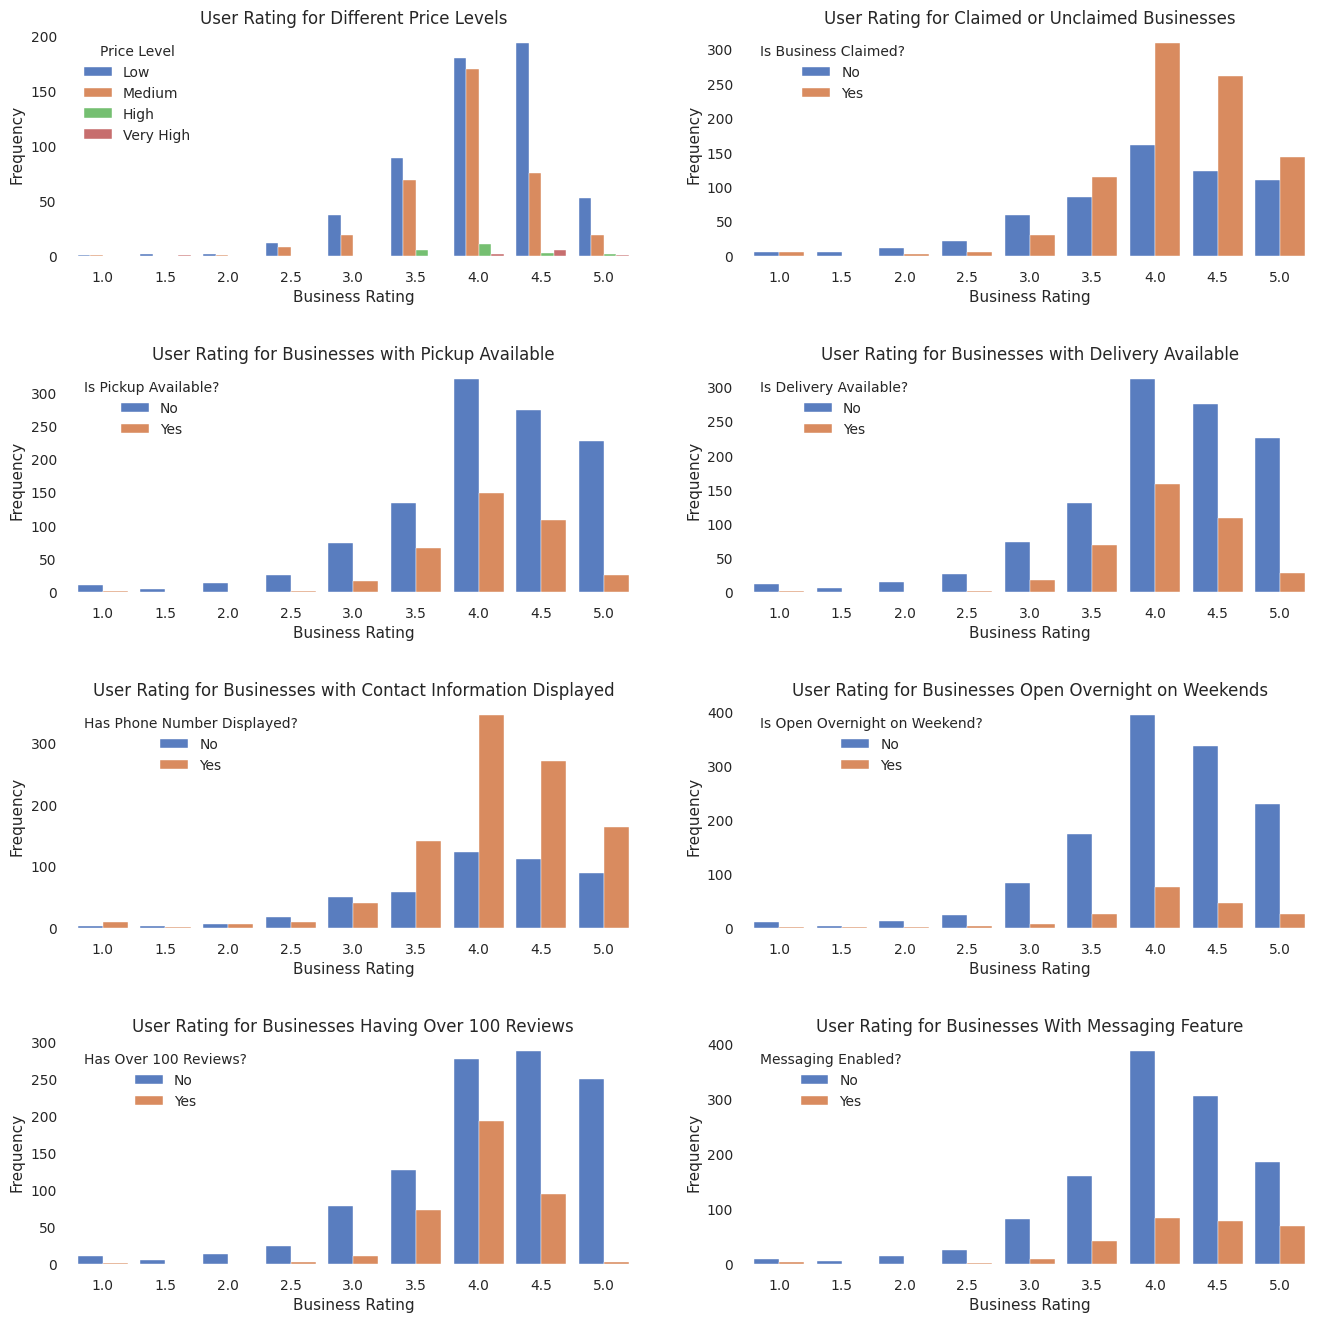

In [15]:
sns.set_style("white")
fig = plt.figure(figsize=(16,16))
fig.subplots_adjust(hspace=0.5, wspace=0.2)

ax = fig.add_subplot(4, 2, 1)
sns.countplot(x = 'rating', hue = 'price_level', data = data_sub7[data_sub7.price_level != 0], palette = 'muted')
ax.set(title = "User Rating for Different Price Levels", xlabel= "Business Rating", ylabel= "Frequency")
ax.legend(title='Price Level', loc='upper left', labels=['Low', 'Medium', 'High', 'Very High'])


ax = fig.add_subplot(4, 2, 2)
sns.countplot(x = 'rating', hue = 'is_claimed', data = data_sub7, palette = 'muted')
ax.set(title = "User Rating for Claimed or Unclaimed Businesses", xlabel= "Business Rating", ylabel= "Frequency")
ax.legend(title='Is Business Claimed?', loc='upper left', labels=['No', 'Yes'])


ax = fig.add_subplot(4, 2, 3)
sns.countplot(x = 'rating', hue = 'pickup', data = data_sub7, palette = 'muted')
ax.set(title = "User Rating for Businesses with Pickup Available", xlabel= "Business Rating", ylabel= "Frequency")
ax.legend(title='Is Pickup Available?', loc='upper left', labels=['No', 'Yes'])


ax = fig.add_subplot(4, 2, 4)
sns.countplot(x = 'rating', hue = 'delivery', data = data_sub7, palette = 'muted')
ax.set(title = "User Rating for Businesses with Delivery Available", xlabel= "Business Rating", ylabel= "Frequency")
ax.legend(title='Is Delivery Available?', loc='upper left', labels=['No', 'Yes'])


ax = fig.add_subplot(4, 2, 5)
sns.countplot(x = 'rating', hue = 'has_display_phone', data = data_sub7, palette = 'muted')
ax.set(title = "User Rating for Businesses with Contact Information Displayed", xlabel= "Business Rating", ylabel= "Frequency")
ax.legend(title='Has Phone Number Displayed?', loc='upper left', labels=['No', 'Yes'])


ax = fig.add_subplot(4, 2, 6)
sns.countplot(x = 'rating', hue = 'is_overnight_weekend', data = data_sub7, palette = 'muted')
ax.set(title = "User Rating for Businesses Open Overnight on Weekends", xlabel= "Business Rating", ylabel= "Frequency")
ax.legend(title='Is Open Overnight on Weekend?', loc='upper left', labels=['No', 'Yes'])


ax = fig.add_subplot(4, 2, 7)
sns.countplot(x = 'rating', hue = 'reviews_more_than_hundred', data = data_sub7, palette = 'muted')
ax.set(title = "User Rating for Businesses Having Over 100 Reviews", xlabel= "Business Rating", ylabel= "Frequency")
ax.legend(title='Has Over 100 Reviews?', loc='upper left', labels=['No', 'Yes'])


ax = fig.add_subplot(4, 2, 8)
sns.countplot(x = 'rating', hue = 'has_messaging_enabled', data = data_sub7, palette = 'muted')
ax.set(title = "User Rating for Businesses With Messaging Feature", xlabel= "Business Rating", ylabel= "Frequency")
ax.legend(title='Messaging Enabled?', loc='upper left', labels=['No', 'Yes'])


sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 1})
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

[Text(0, 0, 'Food Trucks'),
 Text(0, 0, 'Food Stands'),
 Text(0, 0, 'Street Vendors'),
 Text(0, 0, 'Halal'),
 Text(0, 0, 'Chinese'),
 Text(0, 0, 'Mexican'),
 Text(0, 0, 'Sandwiches'),
 Text(0, 0, 'Burgers'),
 Text(0, 0, 'Tacos'),
 Text(0, 0, 'Breakfast & Brunch'),
 Text(0, 0, 'Coffee & Tea'),
 Text(0, 0, 'Cocktail Bars'),
 Text(0, 0, 'Caterers'),
 Text(0, 0, 'Barbeque')]

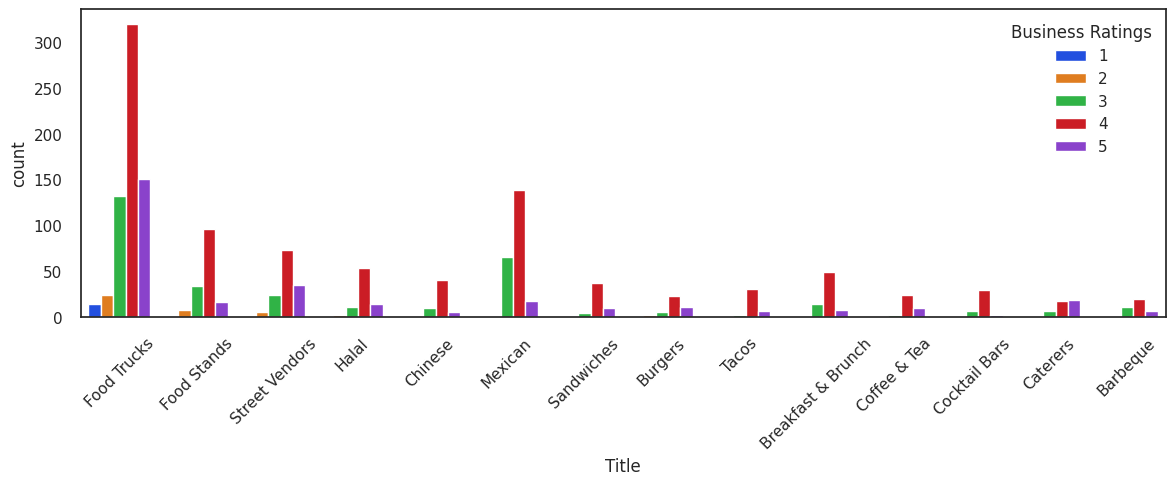

In [16]:
data_sub7_3 = data_sub7[['Title1', 'Title2', 'Title3', 'rating']]
data_sub7_3['rating'] = (data_sub3['rating']).fillna(0).astype('int')
data_sub7_3 = data_sub7_3.melt(id_vars=['rating'], var_name='Name', value_name='Title')

grp_Title = data_sub7_3[['Title']]
grp_Title.fillna(0, inplace=True)
grp_Title['freq'] = grp_Title.groupby(['Title'])['Title'].transform('count').astype(int)
grp_Title = grp_Title.loc[grp_Title.duplicated(subset = ['Title'], keep = 'first') == False]
grp_Title.sort_values('freq')

sns.set_style("white")
g = sns.countplot(x = 'Title', data = data_sub7_3[data_sub7_3['Title'].isin(grp_Title.nlargest(15, 'freq').Title)], hue = 'rating', palette = 'bright', dodge = True )
fig = plt.gcf()
fig.set_size_inches( 14, 4)
g.legend(title = "Business Ratings", loc='upper right')
g.set_xticklabels(g.get_xticklabels(), rotation=45)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


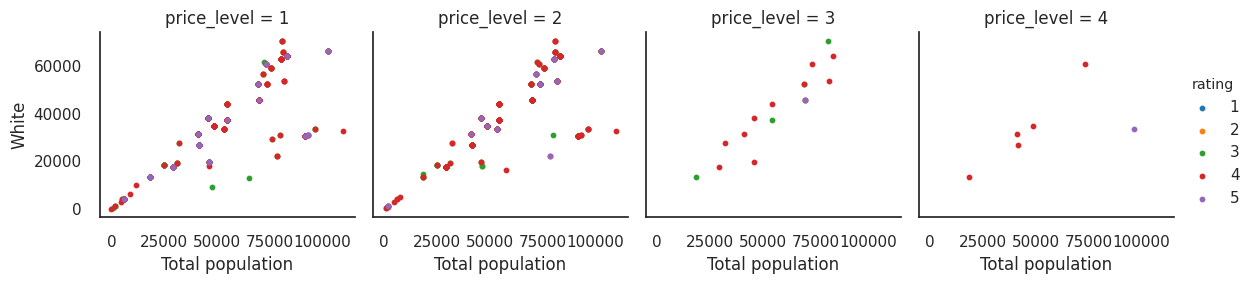

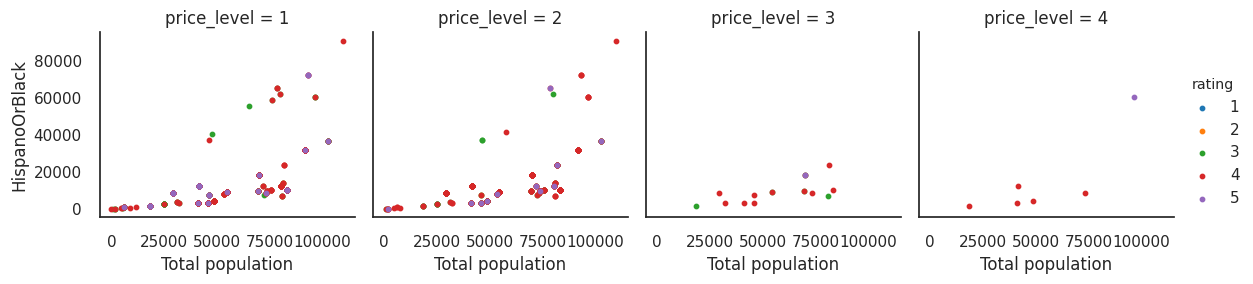

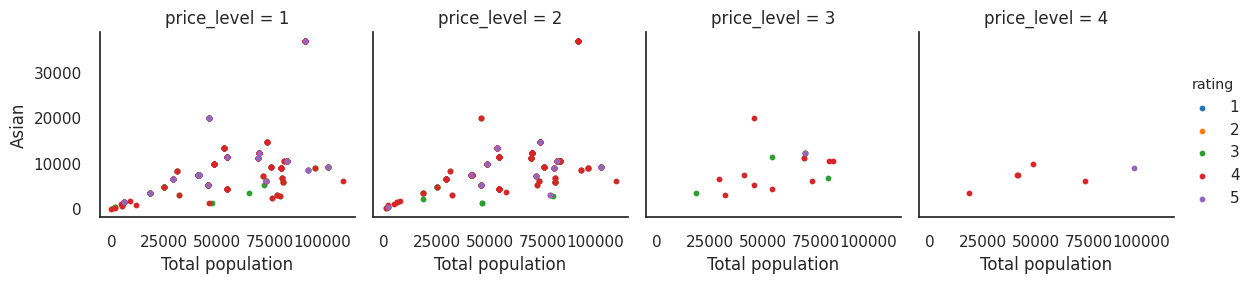

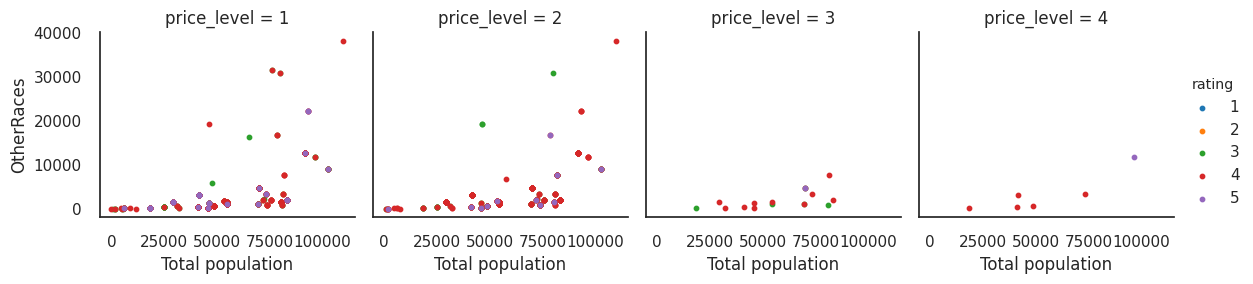

In [17]:
data_sub7_4 = data_sub7[['rating', "Total population", "White", 'HispanoOrBlack', 'Asian', 'OtherRaces', 'price_level' ]]
data_sub7_4['rating'] = (data_sub7_4['rating']).fillna(0).astype('int')
#data_sub7_3 = data_sub7_3[(data_sub7_3['rating'] > 2) & (data_sub7_3['price_level'] != 0) & (data_sub7_3['price_level'] != 3) & (data_sub7_3['price_level'] != 4)]
data_sub7_4 = data_sub7_4[(data_sub7_4['rating'] !=0) & (data_sub7_4['price_level'] != 0)]
data_sub7_4 = data_sub7_4[data_sub7_4.White > 0]


g = sns.FacetGrid(data_sub7_4, col="price_level", hue= "rating", height= 3, aspect= 1)
g.map(plt.scatter, "Total population", "White", s=10 )
g.add_legend()

g = sns.FacetGrid(data_sub7_4, col="price_level", hue= "rating", height= 3, aspect= 1)
g.map(plt.scatter, "Total population", "HispanoOrBlack" , s=10)
g.add_legend()

g = sns.FacetGrid(data_sub7_4, col="price_level", hue= "rating", height= 3, aspect= 1)
g.map(plt.scatter, "Total population", "Asian", s=10 )
g.add_legend()

g = sns.FacetGrid(data_sub7_4, col="price_level", hue= "rating", height= 3, aspect= 1)
g.map(plt.scatter, "Total population", "OtherRaces" , s=10)
g.add_legend()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


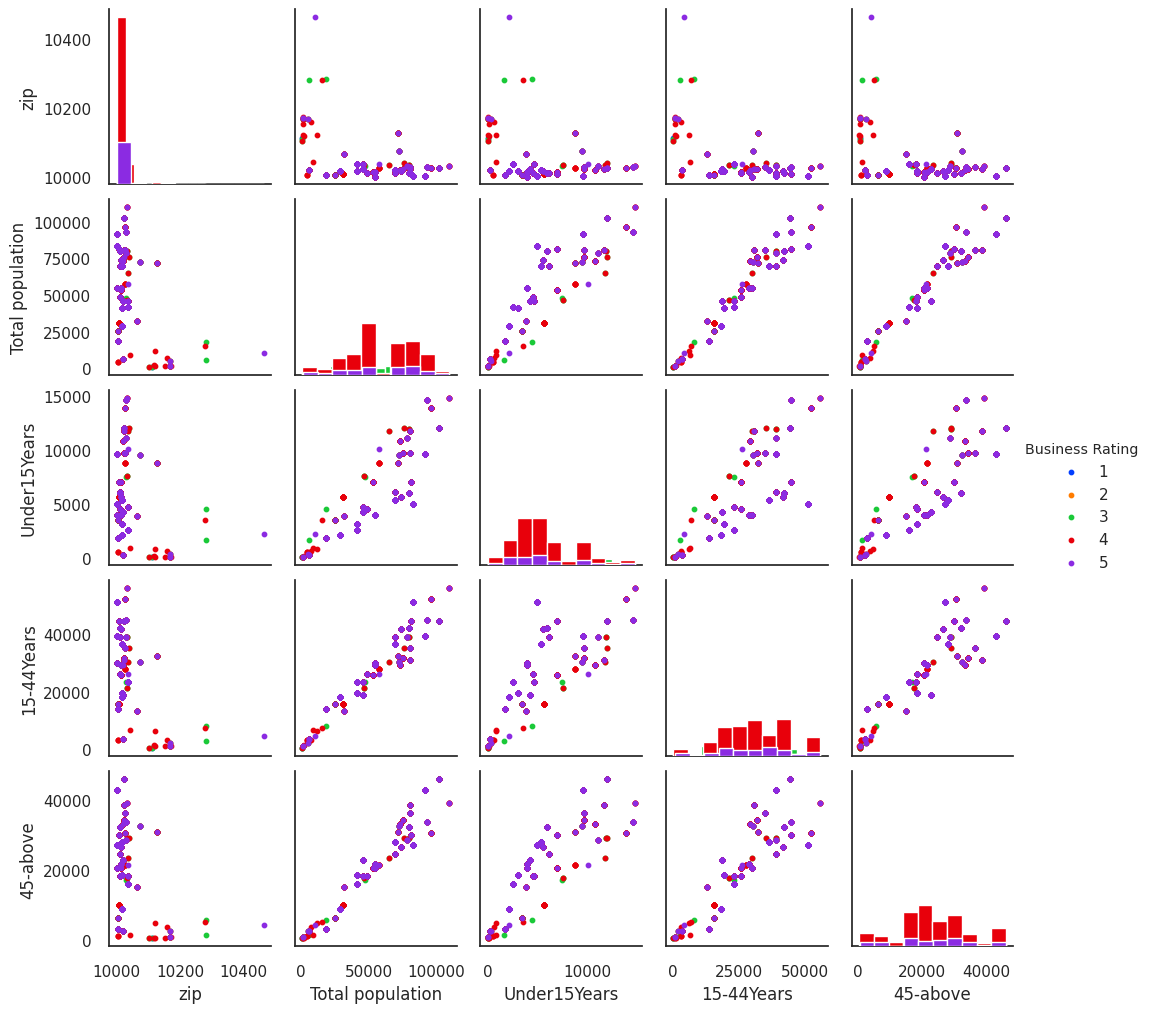

In [18]:
data_sub7_1 = data_sub7[['zip', 'rating', 'Total population',	'Under15Years',	'15-44Years',	'45-above']]
data_sub7_1['rating'] = (data_sub7_1['rating']).fillna(0).astype('int')
data_sub7_1 = data_sub7_1[data_sub7_1.Under15Years > 0]


data_sub7_2 = data_sub7[['zip', 'rating', 'Total population',	'White',	'HispanoOrBlack',	'Asian',	'OtherRaces']]
data_sub7_2['rating'] = (data_sub7_2['rating']).fillna(0).astype('int')
data_sub7_2 = data_sub7_2[data_sub7_2.White > 0]

#grp_zip = data_sub7_1[['zip']]
#grp_zip['freq'] = grp_zip.groupby(['zip'])['zip'].transform('count').astype(int)
#grp_zip = grp_zip.loc[grp_zip.duplicated(subset = ['zip'], keep = 'first') == False]

#g = sns.lmplot(x = "zip" , y = "White" , data = data_sub7_1[data_sub7_1['zip'].isin(grp_zip.nlargest(15, 'freq').zip)], hue = "rating")

g = sns.PairGrid(data_sub7_1, hue= 'rating', height = 2, palette= 'bright')
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter, s = 10);
g.add_legend(title = "Business Rating");

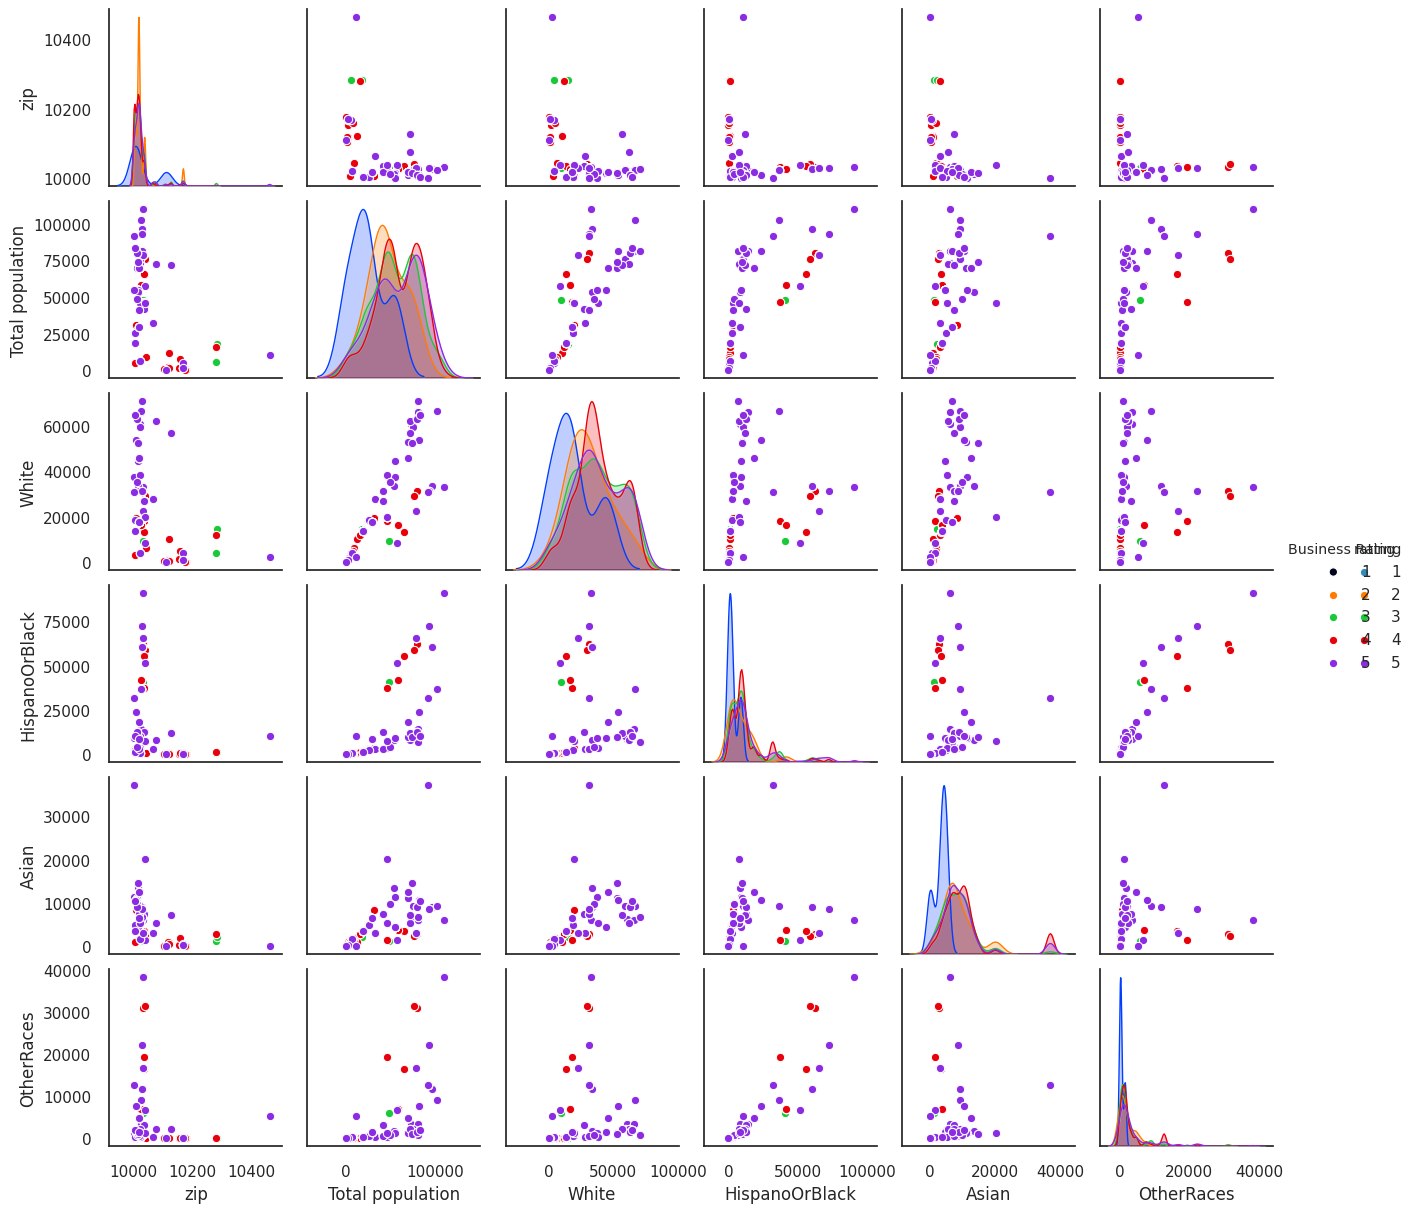

In [19]:
g = sns.pairplot(data_sub7_2, hue="rating", palette="bright", diag_kind="kde", height=2)
g.add_legend(title = "Business Rating");

# IGNORE -  Get the top 10 frequencies per city 

#### Group by Title1 and City

In [0]:
grp_TitleCity = data_sub4[['Title1', 'City']]
grp_TitleCity['freq'] = grp_TitleCity.groupby(['Title1', 'City'])['Title1'].transform('count')

grp_TitleCity = grp_TitleCity.loc[grp_TitleCity.duplicated(subset = ['Title1', 'City'], keep = 'first') == False]
grp_TitleCity = grp_TitleCity.sort_values(by  = 'freq', ascending = False)
grp_TitleCity = grp_TitleCity[:30]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


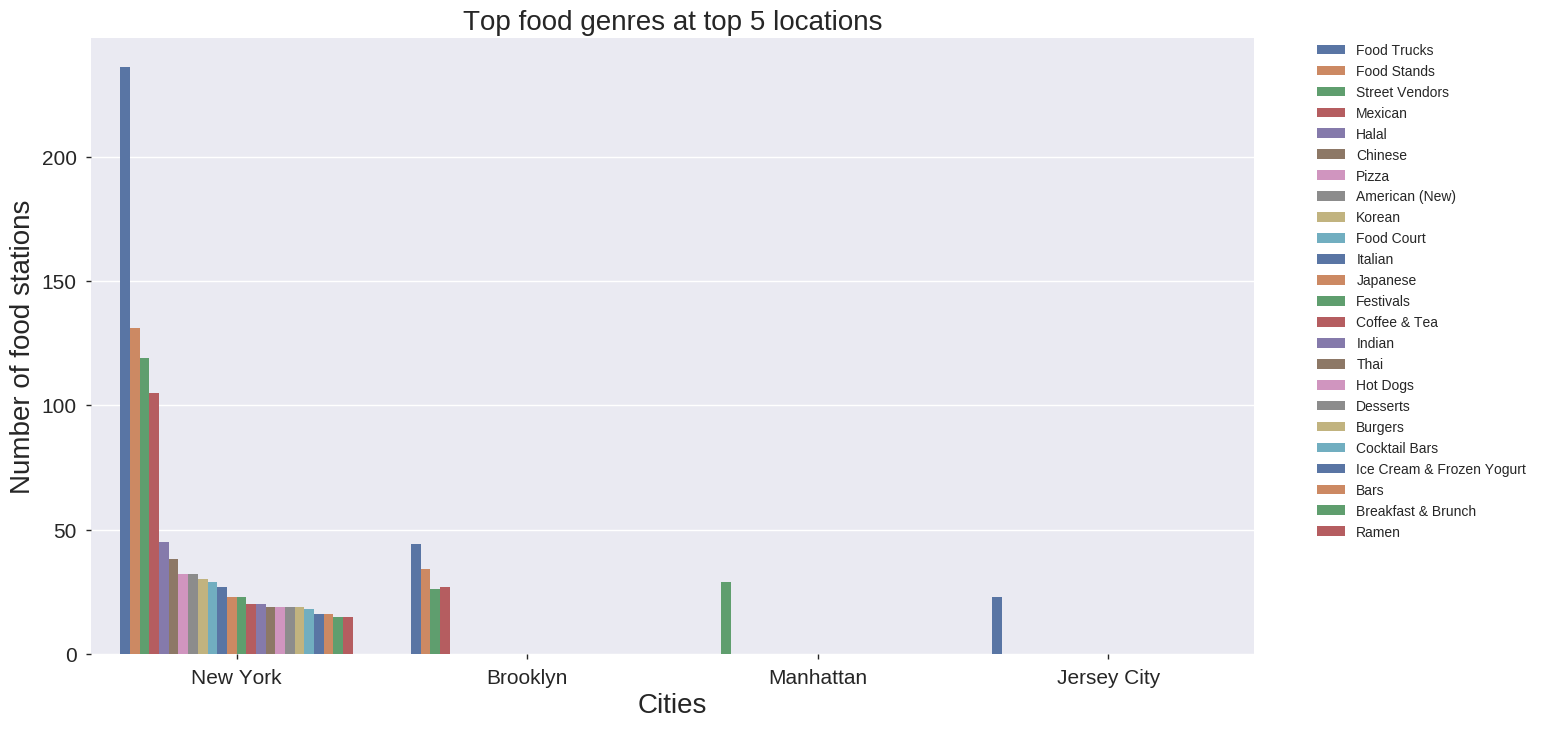

In [0]:
plt.figure(figsize=(15,8))
b = sns.barplot(x = grp_TitleCity.City , y = grp_TitleCity.freq , hue = grp_TitleCity.Title1,  palette="deep", ci = None)
b.axes.set_title("Top food genres at top 5 locations",fontsize=20)
b.set_xlabel("Cities",fontsize=20)
b.set_ylabel("Number of food stations",fontsize=20)
b.tick_params(labelsize=15)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

AttributeError: ignored

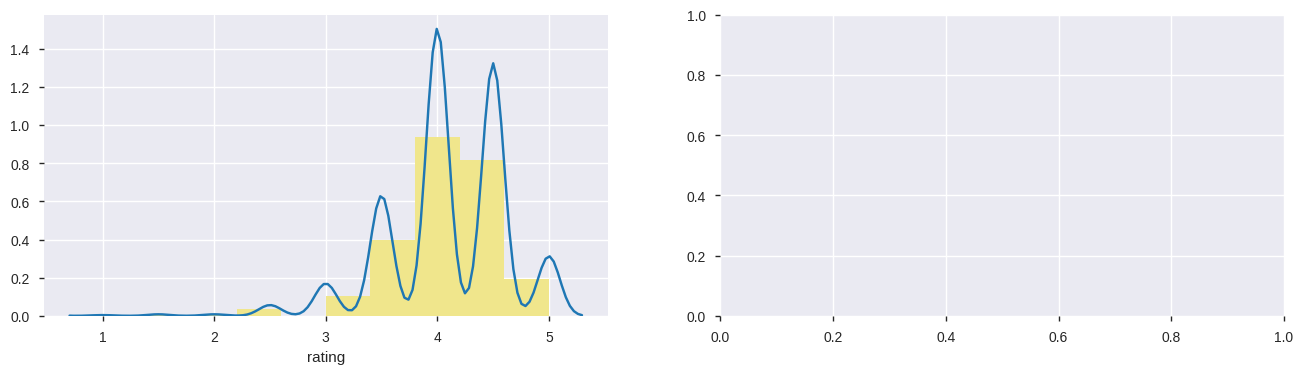

In [0]:
fig = plt.figure(figsize=(16,9))
fig.subplots_adjust(hspace=0.3, wspace=0.2)

ax = fig.add_subplot(2, 2, 1)
sns.distplot(data_sub4.rating, bins=10, hist_kws={"alpha": 1, "color": "khaki", "linewidth": 1})

ax = fig.add_subplot(2, 2, 2)
sns.distplot(data_sub4.pricelevel, bins=5, hist_kws={"alpha": 1, "color": "lightblue", "linewidth": 1})

ax = fig.add_subplot(2, 2, 3)
sns.distplot(data_sub4.review_count, bins=10, hist_kws={"alpha": 1, "color": "palegreen", "linewidth": 1})

ax = fig.add_subplot(2, 2, 4)
sns.distplot(data_sub4.review_count, bins=10, hist_kws={"alpha": 1, "color": "palegreen", "linewidth": 1})

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1})
plt.show()

# Linear Regression Analysis for Feature Extraction

### Determine the statistically significant attributes in the dataset using Advanced Linear Regression With statsmodels



In [30]:
data_reg = data_sub8.copy()
data_reg.head()

,is_claimed,is_closed,review_count,pickup,delivery,reviews_more_than_hundred,has_display_phone,has_messaging_enabled,is_overnight_weekend,price_level,zip,Total population,Under15Years,15-44Years,45-above,White,HispanoOrBlack,Asian,OtherRaces,Title1,Title2,Title3,rating
0,1,0,103.0,0,0,1,1,0,0,1,10020.0,6163.0,237.0,3607.0,2319.0,4066.0,948.0,1574.0,238.0,1,1,0,4.5
1,1,0,495.0,0,0,1,0,1,0,1,10019.0,69890.0,5365.0,36640.0,27885.0,45701.0,18397.0,12454.0,4751.0,2,2,1,4.0
2,1,0,9315.0,0,0,1,0,0,1,1,10019.0,69890.0,5365.0,36640.0,27885.0,45701.0,18397.0,12454.0,4751.0,3,3,2,4.0
3,1,0,1.0,0,0,0,1,1,0,0,10012.0,48786.0,4550.0,25943.0,18293.0,35085.0,4283.0,9860.0,783.0,4,2,0,5.0
4,0,0,111.0,0,0,1,0,0,0,1,10017.0,41121.0,3100.0,19648.0,18373.0,31477.0,3106.0,7395.0,540.0,5,4,0,4.5


In [36]:
import statsmodels.api as sm

x = data_reg[['is_claimed','is_closed','pickup','delivery','price_level','has_display_phone','has_messaging_enabled','is_overnight_weekend','reviews_more_than_hundred', 'review_count', 'Title1', 'Title2', 'Title3']]
x = sm.add_constant(x)
y = data_reg['rating'].astype('int')

model = sm.OLS(y, x)

results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     5.696
Date:                Fri, 20 Mar 2020   Prob (F-statistic):           1.63e-09
Time:                        16:06:28   Log-Likelihood:                -911.23
No. Observations:                 899   AIC:                             1848.
Df Residuals:                     886   BIC:                             1911.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


# Prepare Data for Modeling

In [58]:
data_sub8.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 899 entries, 0 to 1457
Data columns (total 23 columns):
is_claimed                   899 non-null int64
is_closed                    899 non-null int64
review_count                 899 non-null float64
pickup                       899 non-null int64
delivery                     899 non-null int64
reviews_more_than_hundred    899 non-null int64
has_display_phone            899 non-null int64
has_messaging_enabled        899 non-null int64
is_overnight_weekend         899 non-null int64
price_level                  899 non-null int64
zip                          899 non-null float64
Total population             899 non-null float64
Under15Years                 899 non-null float64
15-44Years                   899 non-null float64
45-above                     899 non-null float64
White                        899 non-null float64
HispanoOrBlack               899 non-null float64
Asian                        899 non-null float64
OtherRaces  

In [0]:
data_modelling = data_sub8.drop(['pickup','delivery','has_display_phone', 'has_messaging_enabled', 'is_overnight_weekend', 'is_closed', '15-44Years', '45-above', 'OtherRaces'], axis=1 )

In [22]:
# All the variables should be multiclass
print(utils.multiclass.type_of_target(data_modelling['rating']))
print(utils.multiclass.type_of_target((data_modelling['rating']).astype('int')))

continuous
multiclass


In [66]:
data_modelling['rating'] = (data_modelling['rating']).astype('int')
X = data_modelling.drop('rating', axis=1)
y = data_modelling['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

k =1
seed = 12767
from collections import Counter
from imblearn.over_sampling import SMOTE


print('Original dataset shape %s' % Counter(y))

#sm = SMOTE(sampling_strategy='auto', k_neighbors=k, random_state=seed)
sm = SMOTE( k_neighbors=k, random_state=seed)
X_res, y_res = sm.fit_resample(X_train, y_train)

X_train_sc = preprocessing.scale(X_res)
X_test_sc = preprocessing.scale(X_test)

print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({4: 545, 3: 202, 5: 127, 2: 21, 1: 4})
Resampled dataset shape Counter({4: 428, 5: 428, 3: 428, 2: 428, 1: 428})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [68]:
X_res

X_train_sc

array([[ 1.26050661,  0.75587736,  2.31889252, ...,  0.35776771,
        -0.62142282, -0.33776042],
       [-0.97480231, -0.22220012, -0.46691095, ..., -0.64647379,
        -0.62142282, -0.33776042],
       [ 1.26050661,  0.77359615,  2.31889252, ...,  0.47827669,
        -0.62142282, -0.33776042],
       ...,
       [ 0.95331743, -0.17103315, -0.46691095, ...,  2.56557179,
         0.65938412,  2.49081659],
       [ 1.26050661, -0.19457455, -0.46691095, ..., -0.55193129,
        -0.47508647,  0.26252257],
       [-0.01621387, -0.21916071, -0.46691095, ..., -0.05002258,
        -0.43789997, -0.27525989]])

# ANALYSIS 1 - XGBoost


In [69]:
xg_reg = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.8, learning_rate = 0.1,
                max_depth = 2, alpha = 2, n_estimators = 10)

xg_reg.fit(X_train_sc,y_res)

XGBClassifier(alpha=2, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [70]:
preds_xg_reg = xg_reg.predict(X_test_sc)

rmse_xg_reg = np.sqrt(mean_squared_error(y_test, preds_xg_reg))
print("RMSE: %f" % (rmse_xg_reg))

y_pred_xg_reg = np.ceil(preds_xg_reg)

RMSE: 1.466288


In [71]:
print('XG Boost Confusion Matrix' )
print(metrics.confusion_matrix(y_test,y_pred_xg_reg), '\n')

print('\n\nXG Boost Classification Report' )
print(metrics.classification_report(y_test,y_pred_xg_reg))

# Accuracy : 26%

XG Boost Confusion Matrix
[[ 0  1  0  0  0]
 [ 0  1  1  0  2]
 [ 2  2  9  0 19]
 [ 6  9 44  0 58]
 [ 5  1  0  0 20]] 



XG Boost Classification Report
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.07      0.25      0.11         4
           3       0.17      0.28      0.21        32
           4       0.00      0.00      0.00       117
           5       0.20      0.77      0.32        26

    accuracy                           0.17       180
   macro avg       0.09      0.26      0.13       180
weighted avg       0.06      0.17      0.09       180



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# ANALYSIS 2 - SVM

In [72]:
#svclassifier = SVC(kernel='linear')
svclassifier = SVC( kernel='rbf', C=1.0)
svclassifier.fit(X_train_sc, list(y_res))

y_pred_svm = svclassifier.predict(X_test_sc)

rmse_svm = np.sqrt(mean_squared_error(y_test, y_pred_svm))
print("RMSE: %f" % (rmse_svm))

RMSE: 1.380419


In [74]:
print('SVM Confusion Matrix' )
print(metrics.confusion_matrix(y_test,y_pred_svm), '\n')

print('\n\nSVM Classification Report' )
print(metrics.classification_report(y_test,y_pred_svm))

# Accuracy : 56%

SVM Confusion Matrix
[[ 0  1  0  0  0]
 [ 0  1  1  1  1]
 [ 2  6  9  9  6]
 [ 4 15 24 48 26]
 [ 6  2  4  5  9]] 



SVM Classification Report
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.04      0.25      0.07         4
           3       0.24      0.28      0.26        32
           4       0.76      0.41      0.53       117
           5       0.21      0.35      0.26        26

    accuracy                           0.37       180
   macro avg       0.25      0.26      0.22       180
weighted avg       0.57      0.37      0.43       180



# ANALYSIS 3 - Logistic Regression

In [75]:
classifier = LogisticRegression(solver='sag', max_iter=1000, multi_class='multinomial', C=3.5)
classifier.fit(X_train_sc, y_res)

y_pred_log = classifier.predict(X_test_sc)

rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_log))
print("RMSE: %f" % (rmse_log))

print('Logistic Regression Confusion Matrix' )
print(metrics.confusion_matrix(y_test,y_pred_log), '\n')

print('\n\nLogistic Regression Classification Report' )
print(metrics.classification_report(y_test,y_pred_log))

# Accuracy : 60% 

RMSE: 1.563472
Logistic Regression Confusion Matrix
[[ 0  1  0  0  0]
 [ 1  2  0  1  0]
 [ 2  5  5  2 18]
 [ 6 22 16 32 41]
 [ 7  4  0  0 15]] 



Logistic Regression Classification Report
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.06      0.50      0.11         4
           3       0.24      0.16      0.19        32
           4       0.91      0.27      0.42       117
           5       0.20      0.58      0.30        26

    accuracy                           0.30       180
   macro avg       0.28      0.30      0.20       180
weighted avg       0.67      0.30      0.35       180



# Analysis 4 - Deep Neural Network

In [0]:
X = data_modelling.drop('rating', axis=1)
y = data_modelling['rating']

X_sc = preprocessing.scale(X)
X_train, X_test, y_train, y_test = train_test_split(X_sc, y, test_size = 0.20)

# one hot encode outputs
y_train_o = np_utils.to_categorical(y_train)
y_test_o = np_utils.to_categorical(y_test)
num_classes = y_test_o.shape[1]
num_pixels = X_train.shape[1]

In [99]:
#X_res, y_res, x_test_Sc, y_test

# one hot encode outputs
y_train_o = np_utils.to_categorical(y_res)
y_test_o = np_utils.to_categorical(y_test)
num_classes = y_test_o.shape[1]
num_pixels = X_res.shape[1]
num_classes

6

In [0]:
#hidden_layer_nodes=42

def baseline_model():
    # create model
    model = Sequential()

    #model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='sigmoid'))
    #model.add(Dense(hidden_layer_nodes, kernel_initializer='normal', activation='sigmoid'))
    #model.add(Dense(num_classes, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    #sgd = optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
    #model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

    model.add(Dense(input_dim=num_pixels,output_dim=144, init='normal', activation='tanh'))
    #model.add(layers.Dropout(0.6))

    model.add(Dense(input_dim=144, output_dim=144, init='normal', activation='tanh'))
    #model.add(layers.Dropout(0.6))
    
    model.add(Dense(input_dim=144, output_dim=num_classes, init='normal', activation='softmax'))
    sgd = optimizers.SGD(lr=0.1, decay=1e-7)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

    return model

In [0]:
model = baseline_model()
# Fit the model
nn_simple = model.fit(X_train, y_train_o, validation_data=(X_test, y_test_o), epochs=50, batch_size=150, validation_split=.1)

# Final evaluation of the model
scores = model.evaluate(X_test, y_test_o)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))
print("Baseline Accuracy: %.2f%%" % (scores[1]*100))

In [103]:
model = baseline_model()
# Fit the model
nn_simple = model.fit(X_res, y_train_o, validation_data=(X_test_sc, y_test_o), epochs=50, batch_size=150, validation_split=.1)

# Final evaluation of the model
scores = model.evaluate(X_test, y_test_o)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))
print("Baseline Accuracy: %.2f%%" % (scores[1]*100))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=13, activation="tanh", units=144, kernel_initializer="normal")`
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=144, activation="tanh", units=144, kernel_initializer="normal")`
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=144, activation="softmax", units=6, kernel_initializer="normal")`


Train on 2140 samples, validate on 180 samples
Epoch 1/50
2140/2140 [==============================] - 0s 108us/step - loss: 1.5651 - acc: 0.3150 - val_loss: 1.8075 - val_acc: 0.0778
Epoch 2/50
2140/2140 [==============================] - 0s 22us/step - loss: 1.5065 - acc: 0.3383 - val_loss: 1.8063 - val_acc: 0.0333
Epoch 3/50
2140/2140 [==============================] - 0s 22us/step - loss: 1.4712 - acc: 0.3519 - val_loss: 1.8113 - val_acc: 0.0667
Epoch 4/50
2140/2140 [==============================] - 0s 20us/step - loss: 1.4282 - acc: 0.3720 - val_loss: 1.8026 - val_acc: 0.0611
Epoch 5/50
2140/2140 [==============================] - 0s 20us/step - loss: 1.3997 - acc: 0.3855 - val_loss: 1.8139 - val_acc: 0.0333
Epoch 6/50
2140/2140 [==============================] - 0s 20us/step - loss: 1.4173 - acc: 0.3836 - val_loss: 1.8169 - val_acc: 0.1667
Epoch 7/50
2140/2140 [==============================] - 0s 20us/step - loss: 1.4025 - acc: 0.3939 - val_loss: 1.8238 - val_acc: 0.0278
Epoch 8

In [107]:
y_pred_nn = model.predict(X_test_sc)
y_pred_nn

# Choose the one option with maximum probability and merge it in the Evaluate resultset

array([[0.17634921, 0.21726952, 0.19081199, 0.13794188, 0.1418938 ,
        0.13573363],
       [0.0575964 , 0.24211238, 0.13178346, 0.22305332, 0.18530731,
        0.1601471 ],
       [0.19263102, 0.20575005, 0.23458533, 0.11269617, 0.13768497,
        0.11665241],
       ...,
       [0.09871041, 0.1471113 , 0.1434953 , 0.22800171, 0.18493801,
        0.19774316],
       [0.20268972, 0.21047398, 0.16458152, 0.12987934, 0.14583184,
        0.14654362],
       [0.03812721, 0.722276  , 0.07836935, 0.04249491, 0.08248912,
        0.03624348]], dtype=float32)

In [105]:
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 144)               2016      
_________________________________________________________________
dense_8 (Dense)              (None, 144)               20880     
_________________________________________________________________
dense_9 (Dense)              (None, 6)                 870       
Total params: 23,766
Trainable params: 23,766
Non-trainable params: 0
_________________________________________________________________
None


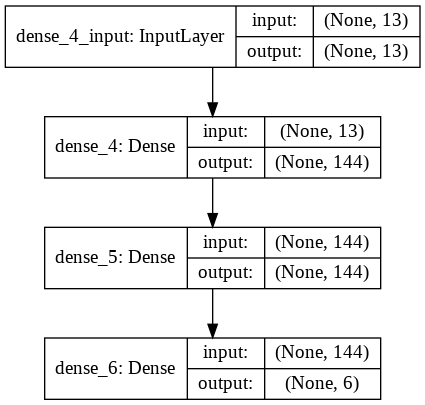

In [102]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [0]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
def plot_history(history):
  acc = history.history['acc']

  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(acc) + 1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, acc, 'b', label='Training acc')
  plt.plot(x, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

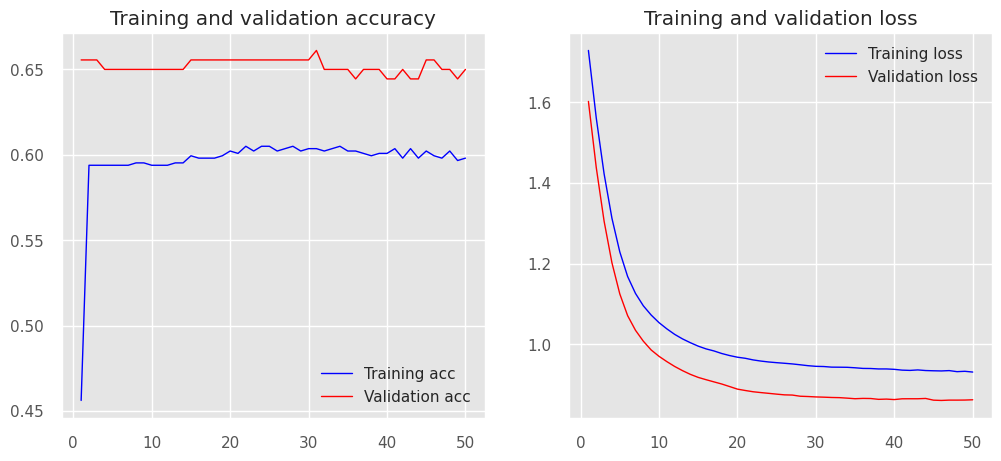

In [39]:
plot_history(nn_simple)

In [92]:
df_Log = pd.DataFrame(y_pred_log)
df_Log.columns = ["Rating_Logistic_Reg"]

df_xgb = pd.DataFrame(preds_xg_reg)
df_xgb.columns = ["Rating_XGBoost"]

df_svm = pd.DataFrame(y_pred_svm)
df_svm.columns = ["Rating_SVM"]

Evaluate = pd.concat([pd.concat([pd.concat([pd.concat([X_test, y_test], axis = 1).reset_index(), df_Log], axis = 1), df_xgb], axis = 1), df_svm], axis = 1)
Evaluate

   Rating_Logistic_Reg
0                    5
1                    5
2                    5
3                    3
4                    5


,index,is_claimed,review_count,reviews_more_than_hundred,price_level,zip,Total population,Under15Years,White,HispanoOrBlack,Asian,Title1,Title2,Title3,rating,Rating_Logistic_Reg,Rating_XGBoost,Rating_SVM
0,115,1,16.0,0,1,10022.0,45637.0,4249.0,38369.0,3289.0,5337.0,1,0,0,4,5,5,5
1,1031,0,1.0,0,0,10075.0,72257.0,9475.0,61892.0,7811.0,5383.0,33,0,0,5,5,1,5
2,61,1,16.0,0,0,10036.0,41611.0,2594.0,26868.0,12630.0,7442.0,20,28,18,4,5,5,5
3,1429,1,201.0,1,3,10005.0,18466.0,1789.0,13515.0,1519.0,3519.0,40,11,0,3,3,3,3
4,438,0,1.0,0,0,10007.0,30983.0,5627.0,19340.0,3524.0,8420.0,60,2,0,4,5,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,1110,1,5.0,0,0,10023.0,75711.0,9691.0,59261.0,10401.0,9337.0,52,114,0,5,5,5,3
176,111,0,46.0,0,1,10019.0,69890.0,5365.0,45701.0,18397.0,12454.0,1,12,0,4,2,5,2
177,1208,0,13.0,0,0,10010.0,69685.0,6127.0,52614.0,9831.0,11203.0,41,0,0,4,5,5,1
178,384,1,2.0,0,2,10017.0,41121.0,3100.0,31477.0,3106.0,7395.0,1,0,0,5,5,5,3
